In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
np.random.seed(100)

4 Physical GPUs, 1 Logical GPU


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
latent_dim = 50
base_window_size = 10
Fs = 25
n_timesteps = base_window_size*Fs
n_channels = 3

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



encoder_inputs = keras.Input(shape=(n_timesteps, n_channels))

x = layers.Conv1D(100, 20, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.GRU(128,return_sequences=True,activation='tanh')(x)
x = layers.Conv1D(100, 20, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool1D(2)(x)
x = layers.Dropout(.5)(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(20, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(5*125, activation="relu")(latent_inputs)
x = layers.Reshape((125, 5))(x)
x = layers.Conv1DTranspose(125, 125, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv1DTranspose(125, 125, activation="relu", strides=2, padding="same")(x)
x = layers.GRU(10,return_sequences=True,activation='tanh')(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling1D(2,strides=1,padding='same')(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling1D(2,strides=1,padding='same')(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling1D(2,strides=1,padding='same')(x)
x = layers.GRU(n_channels,return_sequences=True,activation='tanh')(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, x, name="decoder")
# decoder = get_generator_model(latent_size=latent_dim)
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            aa = keras.losses.mean_absolute_error(data, reconstruction)
            reconstruction_loss = tf.reduce_sum(tf.reduce_mean(aa))
            print(reconstruction_loss.shape)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            total_loss = reconstruction_loss + kl_loss
#             + .1* kl_loss
#             + kl_loss
        print(total_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
import pickle
import numpy as np
import pandas as pd
X,y = pickle.load(open('./data/10/walking_all_data1.p','rb'))
X = np.concatenate(X[:10])
X.shape

In [ ]:
from scipy.stats import skew,kurtosis
def get_features(a):
    return np.array(list(np.mean(a,axis=0))+list(np.std(a,axis=0))+list(np.percentile(a,80,axis=0))+
list(np.percentile(a,20,axis=0))+list(skew(a,axis=0))+list(kurtosis(a,axis=0)))

In [ ]:
from joblib import Parallel,delayed

In [ ]:
X_features = Parallel(n_jobs=20,verbose=2)(delayed(get_features)(a) for a in X)

In [ ]:
X_features = np.array(X_features)

In [ ]:
.5*X_features.shape[1]*np.log(2*np.pi*np.e)*np.linalg.det(np.cov(X_features.T))

In [ ]:
np.linalg.det(np.cov(X_features[:,:3].T))

In [ ]:
from scipy.stats import norm
norm.fit(X_features)

In [ ]:
X[X>2] = 2
X[X<-2] = -2


In [ ]:
X = X/2

In [ ]:
# X = X[:,:,:1]
X.shape

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X, epochs=300, batch_size=100)

In [ ]:
z_sample = np.array([[xi, yi]])
x_decoded = vae.decoder.predict(z_sample)

In [ ]:
z_sample = vae.encoder.predict(X[:10])[0]

In [ ]:
z_sample.shape

In [ ]:
x_decoded = vae.decoder.predict(z_sample)

In [ ]:
x_decoded.shape

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x_decoded[8])
plt.plot(X[8])

In [ ]:
import shutil

In [ ]:
import pickle
import os

In [ ]:
directory = './results/walking_multiple/'

In [ ]:
results = []
for f in os.listdir(directory):
    df = pickle.load(open(directory+f,'rb'))
    results.append(df)

In [ ]:
import pandas as pd

In [ ]:
pickle.dump(pd.concat(results),open('./data/walking_multiple_iterations.p','wb'))

In [49]:
import tensorflow as tf
import pickle

In [50]:
model = tf.keras.models.load_model('./models/10/walking/120/300persons.hdf5')
final_model = tf.keras.models.Model(model.input,model.layers[-3].output)
final_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_94_input (InputLayer) [(None, 250, 3)]          0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 250, 128)          896       
_________________________________________________________________
max_pooling1d_94 (MaxPooling (None, 125, 128)          0         
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 125, 128)          32896     
_________________________________________________________________
max_pooling1d_95 (MaxPooling (None, 62, 128)           0         
_________________________________________________________________
activation_47 (Activation)   (None, 62, 128)           0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 62, 128)           0   

In [51]:
users = pickle.load(open('./models/10/walking/120/300user_dict.p','rb'))

In [52]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
X,y = pickle.load(open('./data/10/walking_all_data1.p','rb'))
y_participant = []
features = []
for i in range(len(X)):
    if len(X[i])<1100:
        continue
    y_participant.extend([y[i]]*len(X[i])) 
    features.append(PCA(n_components=200).fit_transform(final_model.predict(X[i])))
    print(features[-1].shape,end=',')
y = np.array(y_participant)
X = np.concatenate(X)

(1392, 200),(3416, 200),(1707, 200),(2658, 200),(6000, 200),(1213, 200),(3858, 200),(6000, 200),(2886, 200),(2486, 200),(6000, 200),(3025, 200),(4000, 200),(1813, 200),(2165, 200),(1689, 200),(4003, 200),(2298, 200),(1547, 200),(6000, 200),(1387, 200),(3276, 200),(2594, 200),(1688, 200),(4680, 200),(3135, 200),(1159, 200),(2384, 200),(1393, 200),(2895, 200),(2531, 200),(2365, 200),(1743, 200),(1961, 200),(1355, 200),(2001, 200),(1518, 200),(2378, 200),(2578, 200),(1991, 200),(1483, 200),(3488, 200),(1458, 200),(1769, 200),(3315, 200),(2551, 200),(3818, 200),(2116, 200),(3731, 200),(5282, 200),(3488, 200),(6000, 200),(2001, 200),(1754, 200),(2224, 200),(2997, 200),(3099, 200),(2434, 200),(2944, 200),(1602, 200),(1775, 200),(2284, 200),(1106, 200),(3001, 200),(2363, 200),(4581, 200),(1540, 200),(1196, 200),(1650, 200),(1850, 200),(1145, 200),(2291, 200),(1907, 200),(1798, 200),(3087, 200),(2791, 200),(1221, 200),(2104, 200),(1213, 200),(1954, 200),(2188, 200),(1618, 200),(5056, 200),(271

In [53]:
features = np.concatenate(features)

In [54]:
features1 = features.copy()

In [55]:
features = PCA(n_components=200).fit_transform(features1)

In [56]:
X.shape,y.shape,features.shape

((660863, 250, 3), (575593,), (575593, 200))

In [57]:
features.shape

(575593, 200)

In [60]:
unique_users = np.unique(list(users.keys()))
user_df =pd.DataFrame({'user':np.unique(y)})
index_df = pd.DataFrame({'user':y,'index':np.arange(len(y))})
n_users = np.arange(1,10,1)
n_iter = 100

def get_average_entropy(n_user,n_iter):
    result = []
    for k in range(n_iter):
        temp_users = np.unique(user_df.sample(n_user,replace=False)['user'].values)
    #     print(temp_users)
        index = index_df[index_df.user.isin(temp_users)]['index'].values
        temp_feature = features[index]
        d  = 200
        entropy = .5*np.log(np.linalg.det(np.cov(temp_feature[:,:d].T))) + (d/2)*(1+np.log(2*np.pi))
        result.append(entropy)
    return np.array([n_user,np.mean(result)])
from joblib import Parallel,delayed
result = []
for i in range(1,200,20):
    entropies = Parallel(n_jobs=20,verbose=2)(delayed(get_average_entropy)(n_user,n_iter) for i,n_user in enumerate(range(i,i+20)))
    print(entropies)
    result.extend(entropies)
    pickle.dump(result,open('./data/entropies2.p','wb'))
#     result = []
#     for k in range(n_iter):
#         temp_users = np.unique(user_df.sample(n_user,replace=False)['user'].values)
#     #     print(temp_users)
#         index = index_df[index_df.user.isin(temp_users)]['index'].values
#         temp_feature = features[index]
#         d  = 241
#         entropy = .5*np.log(np.linalg.det(np.cov(temp_feature[:,:d].T))) + (d/2)*(1+np.log(2*np.pi))
#         result.append(entropy)
#     print(n_user,np.mean(result))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    7.1s remaining:   40.5s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   19.1s remaining:    8.2s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   25.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([  1.        , 116.55511035]), array([  2.      , 115.210834]), array([  3.        , 117.33868239]), array([  4.        , 117.77183424]), array([  5.        , 118.81493443]), array([  6.        , 117.20062475]), array([  7.        , 118.74165242]), array([  8.        , 116.70782903]), array([  9.        , 116.71604212]), array([ 10.        , 118.92980843]), array([ 11.        , 119.17608135]), array([ 12.        , 118.58638414]), array([ 13.       , 119.8250159]), array([ 14.        , 117.46242086]), array([ 15.        , 117.97718506]), array([ 16.        , 120.43157554]), array([ 17.        , 119.69183514]), array([ 18.        , 121.03629094]), array([ 19.        , 117.90867613]), array([ 20.        , 120.00431548])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   38.8s remaining:  3.7min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   50.3s remaining:   21.6s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   57.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 21.       , 118.6181618]), array([ 22.        , 119.32264575]), array([ 23.        , 118.65697962]), array([ 24.        , 118.89831279]), array([ 25.        , 119.53174199]), array([ 26.        , 118.61203994]), array([ 27.        , 119.17453852]), array([ 28.        , 119.46373825]), array([ 29.       , 118.1448549]), array([ 30.        , 118.69995131]), array([ 31.        , 118.66341592]), array([ 32.        , 119.19102697]), array([ 33.        , 119.09210676]), array([ 34.        , 118.41257107]), array([ 35.        , 119.02070064]), array([ 36.        , 119.16686669]), array([ 37.        , 117.35651422]), array([ 38.        , 119.20316431]), array([ 39.       , 118.8852851]), array([ 40.        , 118.88696611])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   59.1s remaining:  5.6min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  1.4min remaining:   36.7s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  1.5min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 41.        , 119.04339306]), array([ 42.        , 118.70802049]), array([ 43.        , 118.48916285]), array([ 44.        , 119.00237032]), array([ 45.        , 119.63443893]), array([ 46.        , 119.33203253]), array([ 47.        , 119.12965984]), array([ 48.        , 119.81615037]), array([ 49.        , 119.02679968]), array([ 50.        , 119.00357885]), array([ 51.        , 119.30238733]), array([ 52.        , 119.49065398]), array([ 53.        , 118.41764737]), array([ 54.       , 118.3786462]), array([ 55.        , 118.66793184]), array([ 56.        , 118.49575583]), array([ 57.        , 119.19066033]), array([ 58.       , 119.1281406]), array([ 59.       , 118.4837728]), array([ 60.        , 119.08361282])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  1.3min remaining:  7.4min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  2.0min remaining:   50.2s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  2.1min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 61.        , 119.13232107]), array([ 62.        , 118.95407099]), array([ 63.        , 118.75702547]), array([ 64.        , 119.70859532]), array([ 65.        , 118.93307589]), array([ 66.        , 119.47522101]), array([ 67.        , 118.96854922]), array([ 68.        , 118.54385062]), array([ 69.        , 119.16169036]), array([ 70.        , 119.13943121]), array([ 71.        , 118.95895698]), array([ 72.        , 119.21549326]), array([ 73.        , 119.48422503]), array([ 74.        , 118.87765868]), array([ 75.        , 118.78967697]), array([ 76.        , 119.52567221]), array([ 77.        , 119.19145386]), array([ 78.        , 119.19800804]), array([ 79.       , 118.8909944]), array([ 80.        , 119.25219842])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  1.7min remaining:  9.9min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  2.5min remaining:  1.1min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  2.6min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 81.        , 119.49305317]), array([ 82.        , 119.12851787]), array([ 83.      , 118.572504]), array([ 84.       , 119.2651712]), array([ 85.        , 119.50354165]), array([ 86.        , 118.82288024]), array([ 87.        , 119.38007318]), array([ 88.        , 119.43147752]), array([ 89.        , 118.83928473]), array([ 90.        , 119.59522732]), array([ 91.        , 119.29287016]), array([ 92.        , 118.93639928]), array([ 93.       , 119.4954098]), array([ 94.        , 118.50846476]), array([ 95.        , 119.33769438]), array([ 96.        , 119.60876414]), array([ 97.        , 119.23346414]), array([ 98.        , 118.79110525]), array([ 99.        , 119.05633842]), array([100.        , 119.11740904])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  2.1min remaining: 11.9min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  3.0min remaining:  1.3min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  3.2min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([101.        , 119.23546522]), array([102.        , 119.34551024]), array([103.        , 119.23742093]), array([104.       , 119.1052718]), array([105.       , 119.3843555]), array([106.        , 118.99755999]), array([107.        , 119.19724351]), array([108.        , 118.88097078]), array([109.        , 119.41929132]), array([110.       , 119.2293111]), array([111.        , 119.13133887]), array([112.        , 119.01400566]), array([113.        , 119.45644377]), array([114.        , 119.34129918]), array([115.        , 119.12615896]), array([116.       , 119.2027965]), array([117.       , 119.4857686]), array([118.        , 118.80966776]), array([119.        , 119.18180843]), array([120.       , 119.3163633])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  2.5min remaining: 14.2min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  3.6min remaining:  1.5min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  3.7min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([121.       , 119.1135557]), array([122.        , 118.98701833]), array([123.        , 119.36221308]), array([124.        , 119.09905585]), array([125.        , 119.44026715]), array([126.        , 119.06984643]), array([127.        , 118.88741597]), array([128.        , 119.25525539]), array([129.        , 118.94993167]), array([130.        , 119.06302717]), array([131.        , 119.46018799]), array([132.        , 119.32552079]), array([133.        , 119.12860608]), array([134.        , 119.30028769]), array([135.        , 119.12219992]), array([136.        , 119.15958035]), array([137.        , 119.18736315]), array([138.        , 119.21816883]), array([139.        , 119.27350546]), array([140.        , 119.04285942])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  2.9min remaining: 16.2min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  4.1min remaining:  1.8min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  4.4min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([141.        , 119.25836961]), array([142.        , 119.21049603]), array([143.        , 119.41628573]), array([144.        , 118.80982337]), array([145.        , 119.13253734]), array([146.        , 119.00661383]), array([147.        , 118.94567879]), array([148.        , 119.10987889]), array([149.        , 119.04868046]), array([150.        , 119.02169539]), array([151.        , 119.03496092]), array([152.        , 119.27402438]), array([153.       , 119.0176049]), array([154.        , 119.21166649]), array([155.       , 119.4307284]), array([156.        , 119.29182569]), array([157.        , 119.08031153]), array([158.        , 119.41971481]), array([159.        , 118.95784253]), array([160.        , 119.24077048])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  4.9min remaining: 27.7min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  5.1min remaining:  2.2min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  5.2min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([161.        , 119.57199461]), array([162.        , 119.10554223]), array([163.        , 119.24900618]), array([164.      , 119.244451]), array([165.        , 119.27526122]), array([166.        , 119.20999723]), array([167.        , 119.20991751]), array([168.       , 119.2108812]), array([169.        , 119.16886457]), array([170.      , 119.128998]), array([171.        , 119.29851551]), array([172.        , 119.22229507]), array([173.       , 119.2994262]), array([174.        , 119.19091079]), array([175.        , 119.19444367]), array([176.        , 119.00103193]), array([177.        , 119.37646755]), array([178.        , 119.20358261]), array([179.        , 119.23693215]), array([180.        , 119.28524092])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  5.3min remaining: 30.3min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  5.7min remaining:  2.4min


[array([181.        , 119.32346493]), array([182.        , 119.10969227]), array([183.        , 119.18584087]), array([184.        , 119.17541783]), array([185.        , 119.20714912]), array([186.        , 119.38411499]), array([187.        , 119.28091303]), array([188.        , 119.07991924]), array([189.        , 119.25248354]), array([190.        , 119.20607214]), array([191.        , 119.31307727]), array([192.        , 119.34114465]), array([193.        , 119.10646089]), array([194.        , 119.19472989]), array([195.        , 119.30782651]), array([196.        , 119.11848964]), array([197.       , 119.2659112]), array([198.        , 119.21805194]), array([199.        , 119.18208447]), array([200.       , 119.1380421])]


[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  5.8min finished


In [9]:
import pickle
entropies = pickle.load(open('./data/entropies3.p','rb'))

In [10]:
import numpy as np
entropies= np.array(entropies)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
entropies.shape

(200, 2)

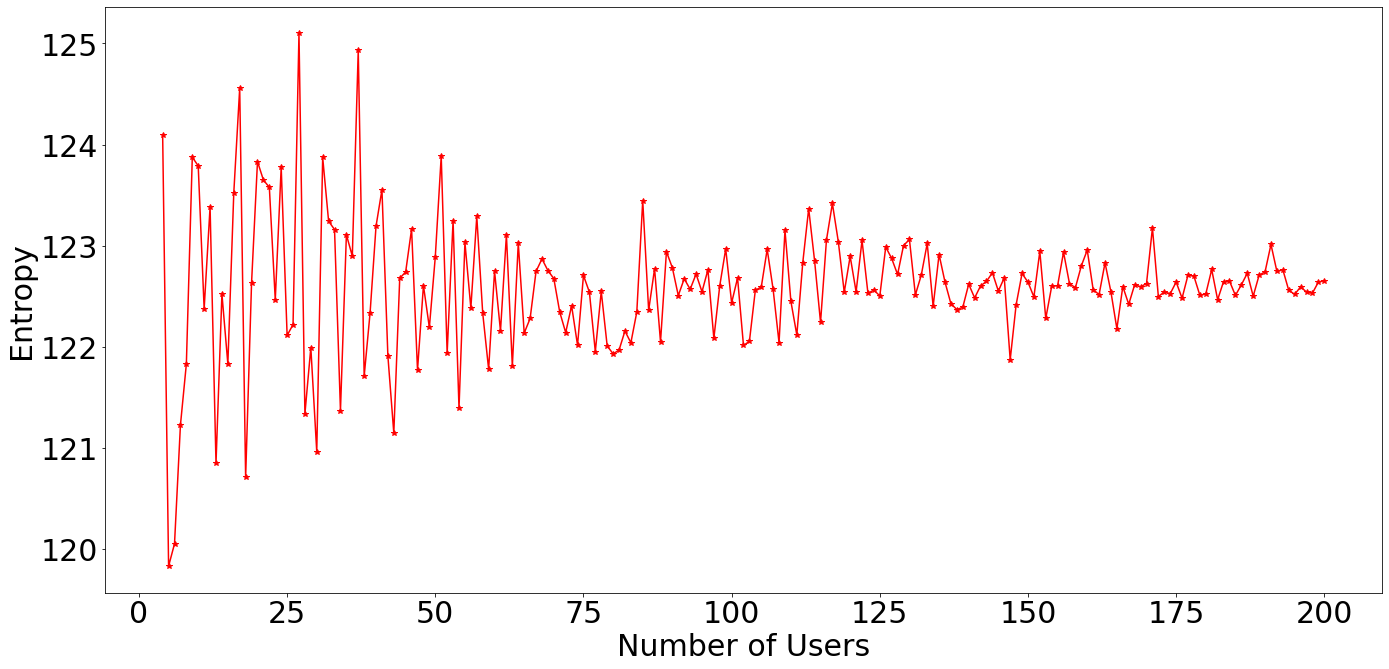

In [13]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':30})
plt.plot(entropies[:,0],entropies[:,1],'r-*')
plt.xlabel('Number of Users')
plt.ylabel('Entropy')
plt.tight_layout()
plt.savefig('./images/entropy3.png')
plt.show()